In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder.master("local[*]").appName("HousingRegression").getOrCreate()

In [3]:
import os
#DIRECTORY = "./MLlib/House_price2/Data.csv"
dataset = spark.read.csv( 
    path = "./MLlib/House_price2/Data.csv", sep=',',header=True, inferSchema=True
)
dataset.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



EDA

In [4]:
dataset.select(F.max(F.col('price')), F.mean(F.col('price')), F.min(F.col('price'))).show()

+----------+-----------------+----------+
|max(price)|       avg(price)|min(price)|
+----------+-----------------+----------+
| 7700000.0|540088.1417665294|   75000.0|
+----------+-----------------+----------+



#### Finding variables correlated with price

In [5]:
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics
import numpy as np
labels  = ['price','sqft_living', 'sqft_lot', 'bedrooms','bathrooms', 'floors', 'sqft_above', 
                  'sqft_basement','yr_built','yr_renovated', 'sqft_living15', 'sqft_lot15']
corr_df = Statistics.corr(dataset.rdd.map(lambda x: np.array([x['price'], x['sqft_living'], x['sqft_lot'],
                                                                        x['bedrooms'], x['bathrooms'], x['floors'],
                                                                        x['sqft_above'], x['sqft_basement'], x['yr_built'],
                                                                        x['yr_renovated'], x['sqft_living15'], x['sqft_lot15']
                                                                       ])), method='pearson')

<AxesSubplot: >

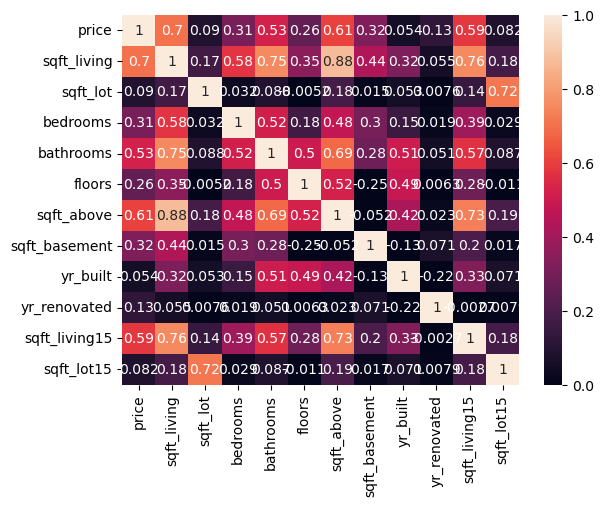

In [6]:
import seaborn as sns
sns.heatmap( corr_df, vmin=0, vmax=1, annot= True, xticklabels = labels, yticklabels = labels)

The factors sqft_living, number of bathrooms, sqft_living15 and sqft_above seem to be highly correlated with price and can be good predictors for price

Find the distribution type of price. (skewed or symmetric)
Find out if there are any missing values in the dataset and your strategy for imputing those.

In [7]:
dataset.select(F.col('price')).summary("25%", "50%", "75%").show()

+-------+--------+
|summary|   price|
+-------+--------+
|    25%|321500.0|
|    50%|450000.0|
|    75%|645000.0|
+-------+--------+



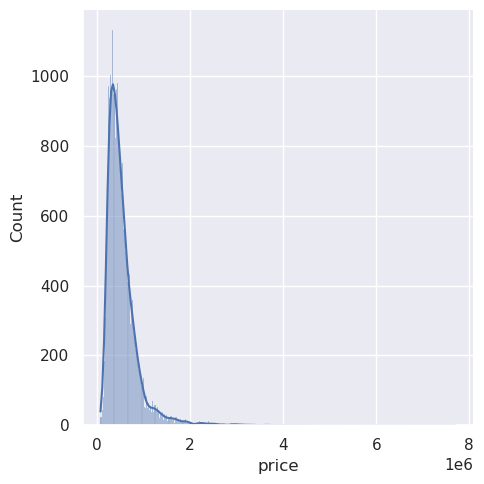

In [8]:
import pandas as pd
price_pd = dataset.select(F.col('price')).toPandas()
sns.set(rc={"figure.figsize": (10, 6)})
sns.displot(price_pd['price'], kde=True)#, norm_hist=True)

https://github.com/mail2sawan/House-Price-Prediction-using-spark-ml-lib/blob/master/House%20Price%20Prediction.ipynb

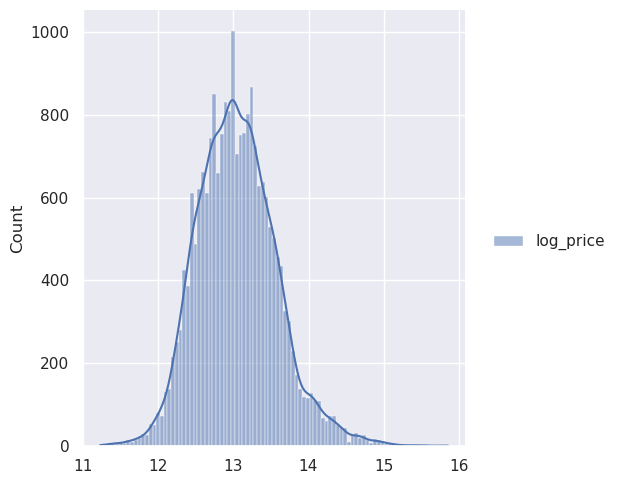

In [9]:
# The price is skewed. Lets make it symmetric.
dataset = dataset.withColumn('log_price', F.log('price'))
sns.set(rc={"figure.figsize": (10, 6)})
sns.displot(dataset.select(F.col('log_price')).toPandas(), kde= True)

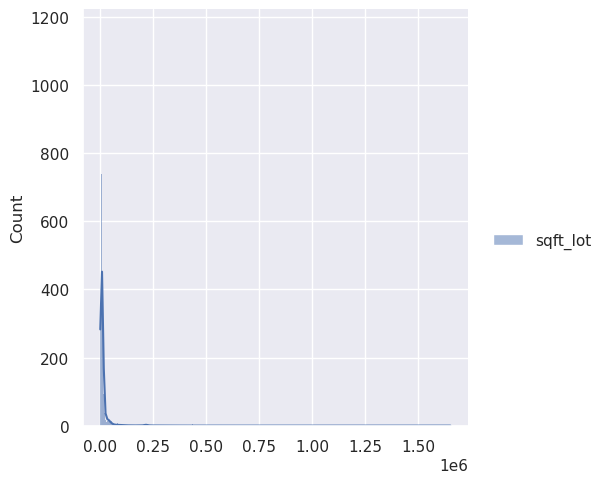

In [10]:
sns.set(rc={"figure.figsize": (8, 4)})
sns.displot(dataset.select(dataset['sqft_lot']).toPandas(), kde=True)

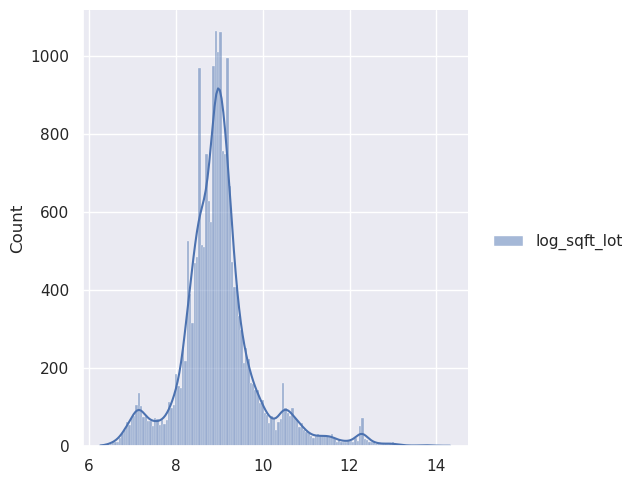

In [11]:
dataset = dataset.withColumn('log_sqft_lot', F.log('sqft_lot'))
sns.displot(dataset.select(dataset['log_sqft_lot']).toPandas(), kde=True)

#### Age of House

In [12]:
# lit() function adds a literal or constant
dataset = dataset.withColumn("age", F.lit(2022) - F.col('yr_built'))
dataset = dataset.withColumn("rennovate_age", F.lit(2022) - F.col('yr_renovated'))

In [13]:
dataset_orig = dataset

In [14]:
dataset.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- log_price: double (nullable = true)
 |-- log_sqft_lot: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- rennovate_age: integer (

In [15]:
continuous_features = ['sqft_living', 'bedrooms', 'bathrooms', 'floors',
                    'log_sqft_lot', 'age', 'sqft_above',
                    'sqft_living15', 'sqft_lot15', 'rennovate_age']

categorical_features = ['zipcode', 'waterfront',
                      'grade', 'condition',
                      'view']

In [16]:
dataset.select(dataset.columns[8:12]).show(5)

+----------+----+---------+-----+
|waterfront|view|condition|grade|
+----------+----+---------+-----+
|         0|   0|        3|    7|
|         0|   0|        3|    7|
|         0|   0|        3|    6|
|         0|   0|        5|    7|
|         0|   0|        3|    8|
+----------+----+---------+-----+
only showing top 5 rows



In [17]:
dataset.select(dataset.columns[16]).show(5)

+-------+
|zipcode|
+-------+
|  98178|
|  98125|
|  98028|
|  98136|
|  98074|
+-------+
only showing top 5 rows



In [18]:
dataset= dataset_orig

In [17]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, PolynomialExpansion, VectorIndexer

def create_category_vars( dataset, field_name ):
    idx_col = field_name + "Index"
    col_vec = field_name + "Vec"
    # for muti value columns Onehot encoder can not directly be applied (expect numeric values).
    # we need to use StringIndexr first to make it numeric so that OHE can accept it.
    cat_stringIndexer = StringIndexer( inputCol=field_name,
                                     outputCol=idx_col).fit(dataset)
    indexed_dataset = cat_stringIndexer.transform( dataset )
    cat_encoder = OneHotEncoder( dropLast=True,
                               inputCol=idx_col,
                               outputCol= col_vec ).fit(indexed_dataset)
    encoded_dataset = cat_encoder.transform(indexed_dataset)
    encoded_dataset = encoded_dataset.drop(idx_col)
    return encoded_dataset

In [19]:
dataset.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- log_price: double (nullable = true)
 |-- log_sqft_lot: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- rennovate_age: integer (

In [20]:
for col in categorical_features:
    dataset = create_category_vars( dataset, col )
dataset.cache()

DataFrame[id: bigint, date: string, price: double, bedrooms: int, bathrooms: double, sqft_living: int, sqft_lot: int, floors: double, waterfront: int, view: int, condition: int, grade: int, sqft_above: int, sqft_basement: int, yr_built: int, yr_renovated: int, zipcode: int, lat: double, long: double, sqft_living15: int, sqft_lot15: int, log_price: double, log_sqft_lot: double, age: int, rennovate_age: int, zipcodeVec: vector, waterfrontVec: vector, gradeVec: vector, conditionVec: vector, viewVec: vector]

In [21]:
dataset.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- log_price: double (nullable = true)
 |-- log_sqft_lot: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- rennovate_age: integer (

In [22]:
dataset.select(dataset.columns[23:]).show(5)

+---+-------------+---------------+-------------+--------------+-------------+-------------+
|age|rennovate_age|     zipcodeVec|waterfrontVec|      gradeVec| conditionVec|      viewVec|
+---+-------------+---------------+-------------+--------------+-------------+-------------+
| 67|         2022|(69,[45],[1.0])|(1,[0],[1.0])|(11,[0],[1.0])|(4,[0],[1.0])|(4,[0],[1.0])|
| 71|           31|(69,[17],[1.0])|(1,[0],[1.0])|(11,[0],[1.0])|(4,[0],[1.0])|(4,[0],[1.0])|
| 89|         2022|(69,[34],[1.0])|(1,[0],[1.0])|(11,[3],[1.0])|(4,[0],[1.0])|(4,[0],[1.0])|
| 57|         2022|(69,[44],[1.0])|(1,[0],[1.0])|(11,[0],[1.0])|(4,[2],[1.0])|(4,[0],[1.0])|
| 35|         2022|(69,[14],[1.0])|(1,[0],[1.0])|(11,[1],[1.0])|(4,[0],[1.0])|(4,[0],[1.0])|
+---+-------------+---------------+-------------+--------------+-------------+-------------+
only showing top 5 rows



#### Final Features

In [22]:
feature_columns = continuous_features + ['zipcodeVec', 'waterfrontVec', 'gradeVec', 'conditionVec', 'viewVec']

In [23]:
feature_columns[0:]

['sqft_living',
 'bedrooms',
 'bathrooms',
 'floors',
 'log_sqft_lot',
 'age',
 'sqft_above',
 'sqft_living15',
 'sqft_lot15',
 'rennovate_age',
 'zipcodeVec',
 'waterfrontVec',
 'gradeVec',
 'conditionVec',
 'viewVec']

### Model Building

In [24]:
# Prepare dataframe for Model building
assembler = VectorAssembler( inputCols = feature_columns, outputCol = "features")
#assembler.outputCol
dataset_model = assembler.transform(dataset)

In [25]:
dataset_model.show(2, truncate=False)

+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------------------+-----------------+---+-------------+---------------+-------------+--------------+-------------+-------------+-------------------------------------------------------------------------------------------------------------------------------------+
|id        |date           |price   |bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat    |long    |sqft_living15|sqft_lot15|log_price         |log_sqft_lot     |age|rennovate_age|zipcodeVec     |waterfrontVec|gradeVec      |conditionVec |viewVec      |features                                                                                                                             |
+----------+---------------+--------+--------+--

In [27]:
#dataset_model.select(dataset_model['features']).show(5, truncate=False)

In [28]:
dataset_model.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)
 |-- log_price: double (nullable = true)
 |-- log_sqft_lot: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- rennovate_age: integer (

In [26]:
dataset_model = dataset_model.withColumn("label", F.round('log_price',4))
dataset_model = dataset_model.select(dataset_model['features'],dataset_model['label'],dataset_model['price'])
dataset_model.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------+-------+--------+
|features                                                                                                                             |label  |price   |
+-------------------------------------------------------------------------------------------------------------------------------------+-------+--------+
|(99,[0,1,2,3,4,5,6,7,8,9,55,79,80,91,95],[1180.0,3.0,1.0,1.0,8.639410824140487,67.0,1180.0,1340.0,5650.0,2022.0,1.0,1.0,1.0,1.0,1.0])|12.31  |221900.0|
|(99,[0,1,2,3,4,5,6,7,8,9,27,79,80,91,95],[2570.0,3.0,2.25,2.0,8.887652690325586,71.0,2170.0,1690.0,7639.0,31.0,1.0,1.0,1.0,1.0,1.0]) |13.1956|538000.0|
|(99,[0,1,2,3,4,5,6,7,8,9,44,79,83,91,95],[770.0,2.0,1.0,1.0,9.210340371976184,89.0,770.0,2720.0,8062.0,2022.0,1.0,1.0,1.0,1.0,1.0])  |12.1007|180000.0|
|(99,[0,1,2,3,4,5,6,7,8,9,54,79,80,93,95],[1960.0,4.0,3.0,1.0,8.517193191416238,57

In [27]:
train_df, test_df = dataset_model.randomSplit( [0.7, 0.3], seed = 42 )
train_df.describe().show(5, truncate=False)

+-------+------------------+-----------------+
|summary|label             |price            |
+-------+------------------+-----------------+
|count  |15208             |15208            |
|mean   |13.047793575749628|539621.7549973698|
|stddev |0.526256962975862 |361441.0921116018|
|min    |11.2252           |75000.0          |
|max    |15.7449           |6885000.0        |
+-------+------------------+-----------------+



## Linear Regression

In [29]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor, RandomForestRegressor

In [30]:
#from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
linreg = LinearRegression(featuresCol='features', labelCol='label', maxIter=500, regParam=0.0)
linreg_model = linreg.fit( train_df )
#lm.intercept

In [31]:
unlabeled_data=test_df.select('features')
#unlabeled_data.show(5, truncate=False)
pred=linreg_model.transform(unlabeled_data).alias('linreg_pred') # a dataframe containing exp_pred column
pred = pred.withColumnRenamed('prediction','linreg_pred')
pred.show(5)

+--------------------+------------------+
|            features|       linreg_pred|
+--------------------+------------------+
|(99,[0,1,2,3,4,5,...|12.963247848599986|
|(99,[0,1,2,3,4,5,...|12.984546616829517|
|(99,[0,1,2,3,4,5,...|13.054756176600673|
|(99,[0,1,2,3,4,5,...|12.984723085985477|
|(99,[0,1,2,3,4,5,...|13.009601085739778|
+--------------------+------------------+
only showing top 5 rows



In [32]:
#test_df.printSchema()

pd_df = test_df.select('label').toPandas()
pd_df['linreg_pred'] = pred.select(F.col('linreg_pred')).toPandas()
#pred_aggregate.withColumn('label', (test_df['label'])) #, F.col(''))
#pred_aggregate.show(5)

### DecisionTreeRegressor

In [33]:
dt_reg= DecisionTreeRegressor(featuresCol='features', labelCol='label',maxDepth=15)
dt_reg_model = dt_reg.fit( train_df )
#unlabeled_data=test_df.select('features')
#unlabeled_data.show(5, truncate=False)
pred=dt_reg_model.transform(unlabeled_data) # a dataframe containing exp_pred column
pred = pred.withColumnRenamed('prediction','dtreg_pred')
pd_df['dtreg_pred'] = pred.select(F.col('dtreg_pred')).toPandas()
pred.show(5)

+--------------------+------------------+
|            features|        dtreg_pred|
+--------------------+------------------+
|(99,[0,1,2,3,4,5,...|           12.8866|
|(99,[0,1,2,3,4,5,...|13.061630000000003|
|(99,[0,1,2,3,4,5,...|        13.2758375|
|(99,[0,1,2,3,4,5,...|13.061630000000003|
|(99,[0,1,2,3,4,5,...|13.061630000000003|
+--------------------+------------------+
only showing top 5 rows



In [34]:
# take around 40secs
gb_reg= GBTRegressor(featuresCol='features', labelCol='label',maxDepth=15, seed=42)
gb_reg_model = gb_reg.fit( train_df )
#unlabeled_data=test_df.select('features')
#unlabeled_data.show(5, truncate=False)
pred=gb_reg_model.transform(unlabeled_data) # a dataframe containing exp_pred column
pred = pred.withColumnRenamed('prediction','gbreg_pred')
pd_df['gbreg_pred'] = pred.select(F.col('gbreg_pred')).toPandas()
pred.show(5)

+--------------------+------------------+
|            features|        gbreg_pred|
+--------------------+------------------+
|(99,[0,1,2,3,4,5,...| 12.92603705881599|
|(99,[0,1,2,3,4,5,...|13.190075787519342|
|(99,[0,1,2,3,4,5,...| 13.21675056078036|
|(99,[0,1,2,3,4,5,...|13.113858218236281|
|(99,[0,1,2,3,4,5,...|13.113858218236281|
+--------------------+------------------+
only showing top 5 rows



In [35]:
# take around 40secs
rf_reg= RandomForestRegressor(featuresCol='features', labelCol='label', numTrees=5,maxDepth=10, seed=42)
rf_reg_model = rf_reg.fit( train_df )
#unlabeled_data=test_df.select('features')
#unlabeled_data.show(5, truncate=False)
pred=rf_reg_model.transform(unlabeled_data) # a dataframe containing exp_pred column
pred = pred.withColumnRenamed('prediction','rfreg_pred')
pd_df['rfreg_pred'] = pred.select(F.col('rfreg_pred')).toPandas()
pred.show(5)

+--------------------+------------------+
|            features|        rfreg_pred|
+--------------------+------------------+
|(99,[0,1,2,3,4,5,...|13.025226393607753|
|(99,[0,1,2,3,4,5,...|12.908497977992315|
|(99,[0,1,2,3,4,5,...|13.027626024099044|
|(99,[0,1,2,3,4,5,...|12.973410258406938|
|(99,[0,1,2,3,4,5,...|13.018684425073602|
+--------------------+------------------+
only showing top 5 rows



In [36]:
pd_df.head()

,label,linreg_pred,dtreg_pred,gbreg_pred,rfreg_pred
0,12.9913,12.963248,12.886600,12.926037,13.025226
1,13.1712,12.984547,13.061630,13.190076,12.908498
2,12.9991,13.054756,13.275837,13.216751,13.027626
3,13.1062,12.984723,13.061630,13.113858,12.973410
4,13.0857,13.009601,13.061630,13.113858,13.018684


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

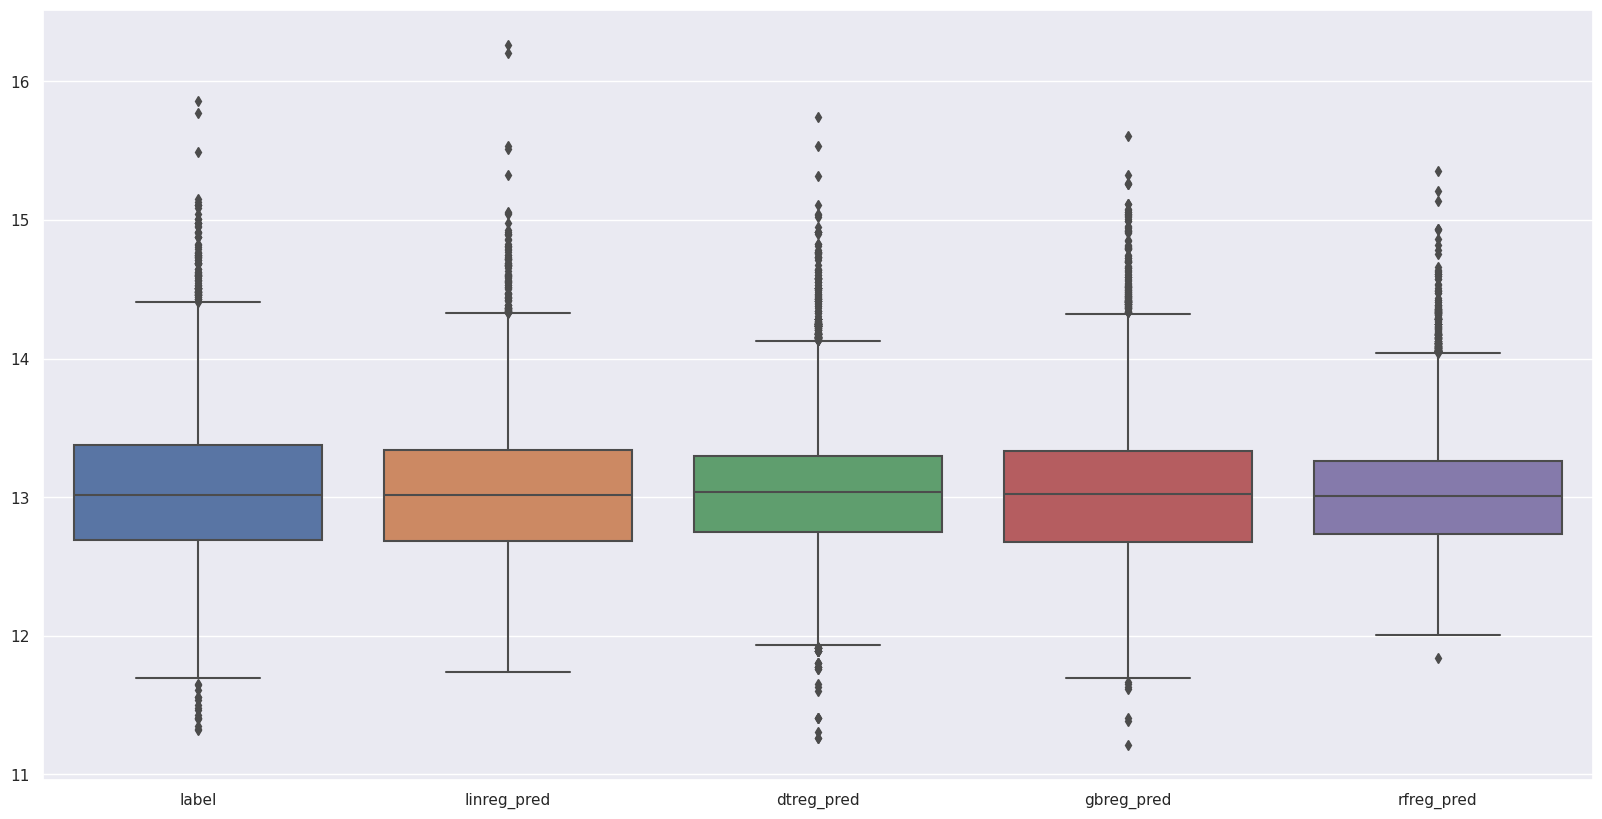

In [37]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=pd_df)

In [38]:
from pyspark.ml.evaluation import RegressionEvaluator
def get_r2_rmse( test_df, col_name ):
    #y_pred = model.transform( test_df )
    #y_pred = y_pred.withColumn( "y_pred", F.exp( 'prediction' ) )
    rmse_evaluator = RegressionEvaluator(labelCol="label", predictionCol=col_name, metricName="rmse" )
    r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol=col_name, metricName="r2" )
    return [np.round( r2_evaluator.evaluate( test_df ), 2), np.round( rmse_evaluator.evaluate( test_df ), 2 )]

In [39]:
sparkDF=spark.createDataFrame(pd_df) 

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


#### Functions for getting r-square and rmse

In [40]:
#r2 coefficient of determination, checks goodness of fit. a score of 1 is perfect fit.

pred_list = ['linreg_pred', 'dtreg_pred', 'gbreg_pred', 'rfreg_pred']
name_list = ['Linear Regression', 'DTRegression','GBRegression', 'RFRegression']
for algo, name in zip(name_list,pred_list):
#col_name = name
    r2_tmp, rmse_tmp = get_r2_rmse( sparkDF, name )
    print(f'For {algo}, r2 score is {r2_tmp}, and RMSE is {rmse_tmp}')
#
#perf_params

For Linear Regression, r2 score is 0.88, and RMSE is 0.18
For DTRegression, r2 score is 0.7, and RMSE is 0.29
For GBRegression, r2 score is 0.74, and RMSE is 0.27
For RFRegression, r2 score is 0.73, and RMSE is 0.28


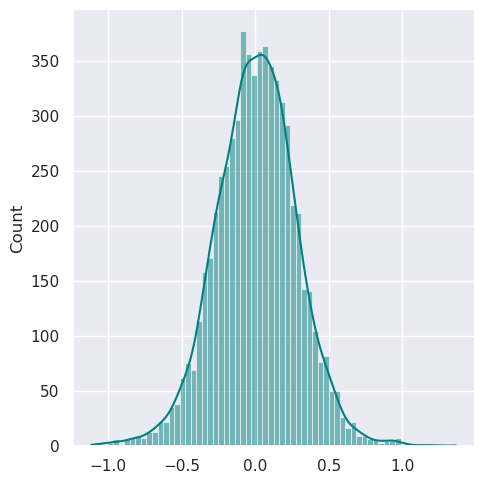

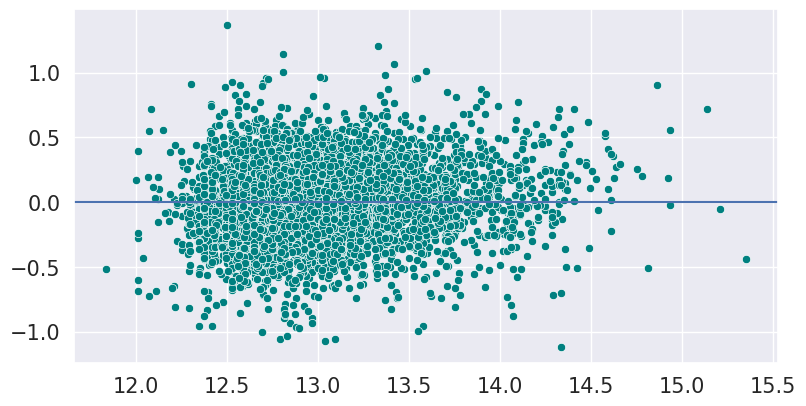

In [41]:
#predicted = regressor.predict(x_test)
# Residual Analysis
col_name = 'rfreg_pred'
predicted = pd_df[col_name].values
residual =  pd_df['label'].values - predicted
#fig = plt.figure(figsize=(30,30))
sns.set(rc={"figure.figsize": (8, 4)})
sns.displot(residual, color ='teal', kde=True)
#axs[0].set_title('Residual counts',fontsize=35)
#axs[0].set_xlabel('Residual',fontsize=25)
#axs[0].set_ylabel('Count',fontsize=25)

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(8, 4))
sns.scatterplot(data=None, x=predicted, y=residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=15)
#axs[0].set_xlabel('Predicted',fontsize=25)
#axs[0].set_ylabel('Residual',fontsize=25)
plt.axhline(y=0)
#axs = axs.flatten()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)